# <대파가격 예측모델 만들기>

> 의생명융합공학부 민수연, 조다영

## 수정된 내용

### 1. 대파 수확시기가 9~11월이므로 올해 재배한 대파가 내년에 판매된다. 따라서 대파의 평균가격을 전년도 날씨와 합쳐서 데이터를 수정하였다.

### 2. 변수선택과정의 경우, 가장 작은 aic값 순서대로 추가하여 변수를 선택하는 전진선택법으로 변경하였다.

---

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.formula.api as smf
import statsmodels.api as sm

plt.rc('font', family='Malgun Gothic')

## 1. 데이터 정리

In [2]:
#서울날씨
seoul=pd.read_csv('108_Seoul_2011~2020.csv',encoding='ANSI')
seoul=seoul.fillna(0)

#대전날씨
daejeon=pd.read_csv('133_Daejeon_2011~2020.csv',encoding='ANSI')
daejeon=daejeon.fillna(0)

#대구날씨
daegu=pd.read_csv('143_Daegu_2011~2020.csv',encoding='ANSI')
daegu=daegu.fillna(0)

#광주날씨
gwangju=pd.read_csv('156_Gwangju_2011~2020.csv',encoding='ANSI')
gwanju=gwangju.fillna(0)

#부산날씨
busan=pd.read_csv('159_Busan_2011~2020.csv',encoding='ANSI')
busan=busan.fillna(0)

#대파가격
vegetable_price=pd.read_csv('vegetable_price.csv',encoding='ANSI')

#대파재배면적
area=pd.read_csv('재배면적.csv',encoding='ANSI')
area['총면적']=area['서울']+area['부산']+area['대구']+area['광주']+area['대전']

### 1-1 서울 데이터를 기준으로 연도, 총면적, 그리고 계절을 설정한다.

In [3]:
year=[]
for i in range(len(seoul.날짜)):
    year.append(seoul.날짜[i][0:4])
seoul['연도']=year


#seoul['연도'] int로 바꿈

seoul=seoul.astype({'연도':int})


#seoul랑 area['총면적'] 연도를 기준으로 합침

seoul=pd.merge(seoul,area[['연도','총면적']],on='연도')



month=[]
for i in range(len(seoul.날짜)):
    month.append(int(seoul.날짜[i][5:7]))
seoul['월']=month


### 1-2 모든 지역의 날씨 데이터의 평균값을 구하고 하나의 데이터프레임에 결합한다.

In [4]:
seoul

지점          날짜  평균기온  일강수량  평균풍속  평균상대습도  합계일조시간   합계일사  평균지면온도    연도  \
0     108  2011-01-01  -6.8   0.0   1.9    61.0     8.8   9.45    -3.5  2011   
1     108  2011-01-02  -5.4   0.0   1.9    62.3     8.9   9.73    -3.4  2011   
2     108  2011-01-03  -4.5   0.0   2.1    66.4     7.1   8.24    -3.1  2011   
3     108  2011-01-04  -3.9   0.0   2.2    66.4     0.6   5.93    -2.7  2011   
4     108  2011-01-05  -4.0   0.0   3.8    62.9     5.0   8.24    -1.7  2011   
...   ...         ...   ...   ...   ...     ...     ...    ...     ...   ...   
3648  108  2020-12-27   5.8   0.0   1.8    62.9     5.9   8.12     1.4  2020   
3649  108  2020-12-28   6.7   1.3   1.4    72.1     8.0   9.12     2.7  2020   
3650  108  2020-12-29   0.1   0.2   2.9    70.8     0.0   1.98    -0.1  2020   
3651  108  2020-12-30 -10.9   0.0   4.1    55.5     8.3  11.36    -4.4  2020   
3652  108  2020-12-31  -8.9   0.0   2.4    53.9     6.0   9.06    -5.0  2020   

      총면적   월  
0     843   1  
1     843   1  
2     843   1  
3     843   1  
4     843   1  
...   ...  ..  
3648  617  12  
3649  617  12  
3650  617  12  
3651  617  12  
3652  617  12  

[3653 rows x 12 columns]

In [6]:
#모든 지역 평균 값

df=pd.concat((seoul,daejeon,daegu,gwangju,busan))
df1=df.groupby(df.index)
data=df1.mean()
data=data.drop(['지점'],axis=1)
data['날짜']=seoul['날짜']

#평균대파가격 data에 추가
data1=pd.merge(data,vegetable_price[['날짜','평균']],on='날짜')
data=data1.rename(columns={'평균':'평균가격'})

#총면적, 서울계절 data에 추가
data['면적']=seoul['총면적']
data=data.astype({'연도':int})

In [7]:
data

평균기온   일강수량  평균풍속  평균상대습도  합계일조시간    합계일사  평균지면온도    연도    총면적     월  \
0    -2.18  0.225  2.14   64.54    5.12   8.310   -1.08  2011  843.0   1.0   
1    -1.34  0.020  2.20   66.04    3.90   7.962   -0.20  2011  843.0   1.0   
2    -0.38  0.020  2.96   57.88    4.02   7.700   -0.24  2011  843.0   1.0   
3    -3.54  0.160  2.68   54.24    7.42  10.196   -1.38  2011  843.0   1.0   
4    -4.22  0.000  2.76   46.02    9.06  11.822   -2.04  2011  843.0   1.0   
...    ...    ...   ...     ...     ...     ...     ...   ...    ...   ...   
2457  5.00  0.000  2.52   56.54    7.18   9.750    4.32  2020  617.0  12.0   
2458  6.06  0.325  1.04   77.82    7.02   9.832    5.20  2020  617.0  12.0   
2459  3.22  2.880  2.06   79.66    2.00   4.882    3.12  2020  617.0  12.0   
2460 -6.46  1.300  4.00   60.82    6.36   9.130   -0.74  2020  617.0  12.0   
2461 -5.78  0.120  2.58   59.36    7.38  11.110   -2.18  2020  617.0  12.0   

              날짜  평균가격   면적  
0     2011-01-03  2880  843  
1     2011-01-04  3120  843  
2     2011-01-05  3020  843  
3     2011-01-06  3220  843  
4     2011-01-07  3420  843  
...          ...   ...  ...  
2457  2020-12-24  2222  713  
2458  2020-12-28  2242  713  
2459  2020-12-29  2302  713  
2460  2020-12-30  2632  713  
2461  2020-12-31  2652  713  

[2462 rows x 13 columns]

In [9]:
#data column 순서 정리
data=data[['날짜','월','연도','평균기온','일강수량','평균풍속','평균상대습도','합계일조시간','합계일사','평균지면온도','면적','평균가격']]

In [10]:
data

날짜     월    연도  평균기온   일강수량  평균풍속  평균상대습도  합계일조시간    합계일사  \
0     2011-01-03   1.0  2011 -2.18  0.225  2.14   64.54    5.12   8.310   
1     2011-01-04   1.0  2011 -1.34  0.020  2.20   66.04    3.90   7.962   
2     2011-01-05   1.0  2011 -0.38  0.020  2.96   57.88    4.02   7.700   
3     2011-01-06   1.0  2011 -3.54  0.160  2.68   54.24    7.42  10.196   
4     2011-01-07   1.0  2011 -4.22  0.000  2.76   46.02    9.06  11.822   
...          ...   ...   ...   ...    ...   ...     ...     ...     ...   
2457  2020-12-24  12.0  2020  5.00  0.000  2.52   56.54    7.18   9.750   
2458  2020-12-28  12.0  2020  6.06  0.325  1.04   77.82    7.02   9.832   
2459  2020-12-29  12.0  2020  3.22  2.880  2.06   79.66    2.00   4.882   
2460  2020-12-30  12.0  2020 -6.46  1.300  4.00   60.82    6.36   9.130   
2461  2020-12-31  12.0  2020 -5.78  0.120  2.58   59.36    7.38  11.110   

      평균지면온도   면적  평균가격  
0      -1.08  843  2880  
1      -0.20  843  3120  
2      -0.24  843  3020  
3      -1.38  843  3220  
4      -2.04  843  3420  
...      ...  ...   ...  
2457    4.32  713  2222  
2458    5.20  713  2242  
2459    3.12  713  2302  
2460   -0.74  713  2632  
2461   -2.18  713  2652  

[2462 rows x 12 columns]

In [11]:
yn=data.groupby(['월','연도'])[['평균기온','일강수량','평균풍속','평균상대습도','합계일조시간','합계일사','평균지면온도','면적']].mean()
yn=yn.reset_index()

In [12]:
data11=data[['연도','월','평균가격']]
index=data11[data11['연도']==2011].index
d11=data11.drop(index)
d11['연도']=d11['연도']-1
mp=d11.groupby(['월','연도'])[['평균가격']].mean()
mp=mp.reset_index()

In [13]:
data_y=pd.merge(yn,mp[['연도','월','평균가격']],on=['연도','월'])
data_y

월    연도      평균기온      일강수량      평균풍속     평균상대습도    합계일조시간       합계일사  \
0     1.0  2011 -3.720952  0.100000  2.507619  49.865714  7.161905  10.657905   
1     1.0  2012  0.204000  0.569000  2.282000  55.746000  5.714000   8.292200   
2     1.0  2013 -0.610000  1.080909  2.249091  57.878182  6.292727   8.987545   
3     1.0  2014  1.159000  0.253250  2.167000  49.715000  7.036000   9.756200   
4     1.0  2015  1.805714  1.310476  2.044762  62.475238  5.565714   8.297524   
..    ...   ...       ...       ...       ...        ...       ...        ...   
103  12.0  2015  4.629524  1.957143  1.960952  69.889524  4.946667   6.953810   
104  12.0  2016  4.109524  2.916190  2.253333  63.709524  5.163810   7.327810   
105  12.0  2017 -0.184211  0.161316  2.041053  51.615789  6.716842   8.472842   
106  12.0  2018  2.730526  1.590000  1.949474  56.048421  5.814737   8.468632   
107  12.0  2019  4.183000  0.372750  2.026000  59.528000  6.110000   8.636300   

       평균지면온도          면적         평균가격  
0   -2.159048  843.000000  1138.000000  
1    0.836000  843.000000  2223.636364  
2    0.145455  490.000000  1235.000000  
3    0.950000  491.000000  1254.761905  
4    1.741905  491.000000  2295.000000  
..        ...         ...          ...  
103  4.383810  526.000000  2527.619048  
104  3.886667  593.619048  1752.631579  
105  0.162105  597.000000  1724.210526  
106  2.678947  688.000000  1769.000000  
107  3.839000  713.000000  2399.809524  

[108 rows x 11 columns]

---

## 2. 대파가격에 영향을 주는 요인 분류

### 2-1 변수 선택1

> 전체데이터 변수들간의 상관관계 그래프

In [ ]:
sns.pairplot(data_y)

## 수정된 내용

### 2-2 변수 선택2 

> aic 값 비교

In [15]:
# 각 독립변수들로 예측모델을 만들어 aic값 비교

result = []

for x in [ '평균기온', '일강수량', '평균풍속','평균상대습도','합계일조시간','합계일사','평균지면온도','면적']:
    formula = f"평균가격 ~ {x}"
    res = smf.ols(formula, data = data_y).fit()
    result.append((res.aic, formula))
    
result

[(1666.4989534480599, '평균가격 ~ 평균기온'),
 (1666.1031460579459, '평균가격 ~ 일강수량'),
 (1657.4448488208855, '평균가격 ~ 평균풍속'),
 (1664.787538531638, '평균가격 ~ 평균상대습도'),
 (1664.8883515222144, '평균가격 ~ 합계일조시간'),
 (1664.7532889061727, '평균가격 ~ 합계일사'),
 (1666.520690965314, '평균가격 ~ 평균지면온도'),
 (1661.4816316283172, '평균가격 ~ 면적')]

In [16]:
#독립변수가 없는 예측모델의 aic값

null=smf.ols(formula = "평균가격~1",data = data_y).fit() 
null.aic

1664.5228212508948

#### aic값이 작은 순서대로 나열

#### (평균풍속-면적-null-합계일사-평균상대습도-합계일조시간-일강수량-평균기온-평균지면온도)

In [19]:
# aic값이 가장 작은 순서대로 독립변수를 하나씩 추가하여 가장 적합한 예측모델을 판별하였다.

lm_null=smf.ols(formula = "평균가격~1",data = data_y).fit() 
lm_1=smf.ols(formula = "평균가격~평균풍속",data = data_y).fit() 
lm_2=smf.ols(formula = "평균가격~평균풍속+면적",data = data_y).fit() 
lm_3=smf.ols(formula = "평균가격~평균풍속+면적+합계일사",data = data_y).fit() 
lm_4=smf.ols(formula = "평균가격~평균풍속+면적+합계일사+평균상대습도",data = data_y).fit() 
lm_5=smf.ols(formula = "평균가격~평균풍속+면적+합계일사+평균상대습도+합계일조시간",data = data_y).fit() 
lm_6=smf.ols(formula = "평균가격~평균풍속+면적+합계일사+평균상대습도+합계일조시간+일강수량",data = data_y).fit() 
lm_7=smf.ols(formula = "평균가격~평균풍속+면적+합계일사+평균상대습도+합계일조시간+일강수량+평균기온",data = data_y).fit() 
lm_full=smf.ols(formula = "평균가격~평균풍속+면적+합계일사+평균상대습도+합계일조시간+일강수량+평균기온+평균지면온도",data = data_y).fit() 

lm_null.aic,lm_1.aic,lm_2.aic,lm_3.aic,lm_4.aic,lm_5.aic,lm_6.aic,lm_7.aic,lm_full.aic

(1664.5228212508948,
 1657.4448488208855,
 1653.313489634195,
 1654.8003176562445,
 1655.0145637757366,
 1656.015798775394,
 1655.5591186647164,
 1657.1428718664645,
 1656.2007562738238)

### [새로운 분석]
#### 독립변수에 평균풍속과 면적이 있는 예측모델이 aic값이 가장 작기 때문에 이 모델을 선택함.

### 2-5 모델 평가

### 잔차 그래프, 잔차 산포도, Q-Q 플롯

In [25]:
lm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   평균가격   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     7.939
Date:                Mon, 21 Jun 2021   Prob (F-statistic):           0.000615
Time:                        23:37:14   Log-Likelihood:                -823.66
No. Observations:                 108   AIC:                             1653.
Df Residuals:                     105   BIC:                             1661.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2408.2519    416.269      5.785      0.000    1582.867    3233.636
평균풍속        -504.4483    156.679     -3.220      0.002    -815.114    -193.783
면적             0.9598      0.388      2.477      0.015       0.191       1.728
==============================================================================
Omnibus:                        8.506   Durbin-Watson:                   1.522
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.907
Skew:                           0.703   Prob(JB):                       0.0116
Kurtosis:                       2.967   Cond. No.                     5.58e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\Users\COM\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


C:\Users\COM\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\COM\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


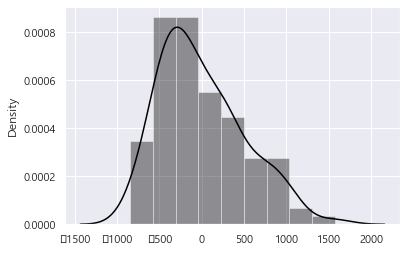

In [21]:
resid=lm_2.resid
sns.distplot(resid, color = 'black')

C:\Users\COM\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\COM\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


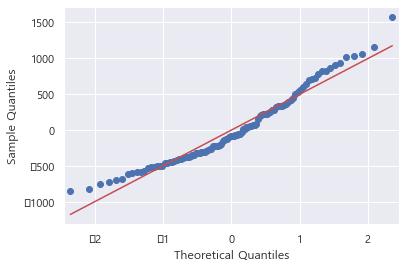

In [22]:
fig = sm.qqplot(resid, line = "s")

C:\Users\COM\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


C:\Users\COM\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\COM\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


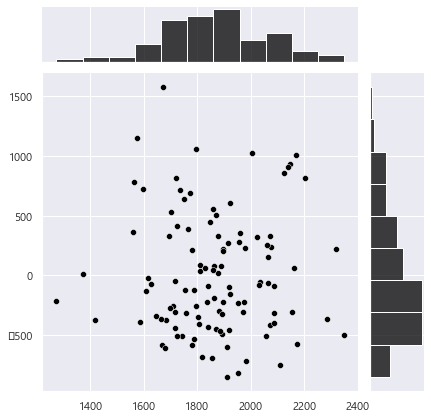

In [24]:
sns.jointplot(lm_2.fittedvalues, resid, 
              joint_kws={"color": "black"}, 
              marginal_kws={"color": "black"})

### [새로운 분석]
#### 1) 잔차 그래프를 보면 잔차가 왼쪽으로 치우친 정규분포를 따르는 것을 알 수 있다.
#### 2) q-q플롯을 보면 빨간 선에서 거의 벗어나지 않는 것을 알 수 있다.
#### 3) 잔차 산포도를 보면 오류에서의 상관관계가 없다.

---

## 3. 대파가격 예측

### 면적

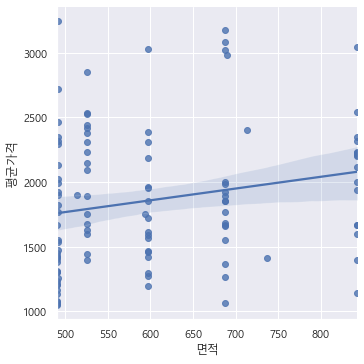

In [26]:
sns.lmplot(x='면적', y='평균가격',  data=data_y)
plt.show()

### 평균풍속

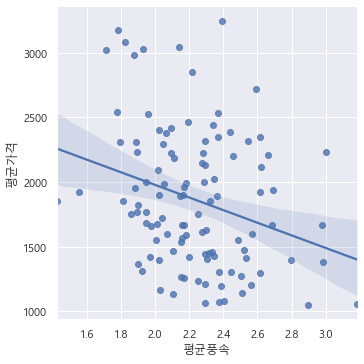

In [27]:
sns.lmplot(x='평균풍속', y='평균가격', data=data_y)
plt.show()

### 예측가격

In [28]:
lm_2.predict()

array([1952.41116137, 2066.22431489, 1744.01076274, 1786.38119979,
       1848.04400373, 1733.71403855, 1887.11263106, 1834.78758076,
       2070.71365741, 2172.87062817, 1977.87379174, 1681.15987894,
       1608.81538491, 1672.99901753, 1718.46189469, 1750.40713154,
       1881.00320119, 2109.558877  , 1715.49514336, 1876.02327023,
       1587.17318865, 1626.56716213, 1573.45814233, 1795.53188939,
       1810.94093207, 1717.25766935, 1912.40859725, 1805.88092993,
       1702.01261507, 1417.49511142, 1793.58105333, 1561.99340738,
       1763.98093881, 1663.13756912, 1778.27189686, 1984.04026121,
       1862.42718646, 2064.83107663, 1666.44364172, 1561.0520923 ,
       1597.10097351, 1754.90086873, 1920.32657161, 1804.38310367,
       1972.75022698, 1894.75992277, 1838.46788396, 1853.73431026,
       1772.92039414, 1810.37284404, 1892.20690199, 1870.9943056 ,
       2055.99052411, 2154.2252004 , 1861.13003359, 1644.49686339,
       1272.22196563, 1723.23742743, 1616.90134956, 1756.72649

In [30]:
data_y['예측가격']=lm_2.predict().round(1)

In [31]:
sns.regplot(data_y.예측가격, data_y.평균가격)

C:\Users\COM\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


C:\Users\COM\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\COM\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'density')

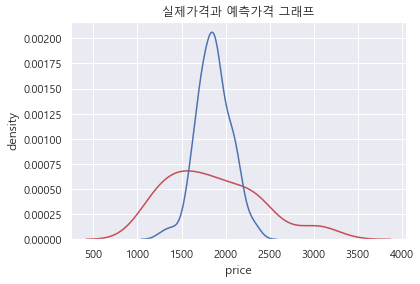

In [32]:
ax1 = sns.distplot(data_y['평균가격'], hist=False, color="r", label="Actual Value")
sns.distplot(data_y['예측가격'], hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('실제가격과 예측가격 그래프')
plt.xlabel('price')
plt.ylabel('density')

## 4. 결론

> 데이터를 수정하여 분석한 결과, 나아진 값을 얻을 수 있었고 이전과는 달리 '평균풍속'과'면적'이 대파가격을 예측하는 데에 영향을 주는 변수로 선택되었다.
>
> 전에 분석한 것 보다 잔차그래프가 정규분포에 더 가깝다.
>
> 또한, durbin-watson값과 결정계수값이 전에 분석한 것보다 높아진 것을 보아 더 유의미한 분석임을 알 수 있다.